# Two-step-task as described in "Prefrontal cortex as a meta-reinforcement learning system"

This iPython notebook includes an implementation of the two-step task as described here: [biorxiv link](https://www.biorxiv.org/content/early/2018/04/13/295964).

The difference with our first trial (in `biorxiv-first-try.ipynb`) is that, in this notebook, **the A2C LSTM receives only actions made at stage 1 and the rewards received after leaving stage 2.** Therefore, the LSTM receives "two-steps in one", as implemented in "trial" from the class "two_step_task()".

Note: in the biorxiv paper, they do not point out to any state in the first_stage, and refer to the second stage states as S_1 and S_2. In this notebook, we use the terminology presented in their [previous work on arxiv](https://arxiv.org/abs/1611.05763), where at the first stage there is one state S_1, and at the second stage there are two states S_2 and S_3.

For this final step, the goal was to reproduce the plots from the [biorxiv pre-print](https://www.biorxiv.org/content/early/2018/04/13/295964) (Simulation 4, Figure b) ). To that end, we launched n=8 trainings using different seeds, but with the same hyperparameters as the paper, to compare to the results obtained by Wang et al.

For each seed, the training consisted of 20k episodes of 100 trials (instead of 10k episodes of 100 trials in the paper). The reason for our number of episodes choice is that, in our case, the learning seemed to converge after around ~20k episodes for most seeds, without any significant gap in reward before ~15k episodes.

 ![reward curve](results/biorxiv/final/reward_curve.png)
 
After training, we tested the 8 different models for 300 further episodes (like in the paper), with the weights of the LSTM being fixed. 

Here is the side by side comparison of our results (on the left) with the results from the paper (on the right):

![side by side](results/biorxiv/final/side_by_side.png)

Running the cells below will reproduce those tests. It will generate 8 different plots of the probabilities of repeating an action for a common/uncommon transition, if the last action was rewarded/unrewarded. Finally, it will average those plots to output a final plot, to reproduce the Figure b) from Simulation 4 in biorxiv. Each datapoint from a different seed is represented by a black dot.


In [1]:
import threading
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from helper import *

from random import choice
from time import sleep
from time import time

/Users/Marvin/opt/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf
import tf_slim as slim
import scipy.signal
from PIL import Image
from PIL import ImageDraw 
from PIL import ImageFont
tf.compat.v1.disable_eager_execution()

### Initialization

In [3]:
# Directories/book-keeping
from datetime import datetime

dir_name = "train_" + datetime.now().strftime("%m%d-%H%M%S")

In [4]:
# encoding of the higher stages
S_1 = 0
S_2 = 1
S_3 = 2
nb_states = 3

### Definition of our environment: the two-step task

In [5]:
class two_step_task():
    def __init__(self):
        # start in S_1
        self.state = S_1
        
        # defines what is the stage with the highest expected reward. Initially random
        self.highest_reward_second_stage = np.random.choice([S_2,S_3])
        
        self.num_actions = 2
        self.reset()
        
        # initialization of plotting variables
        common_prob = 0.8
        self.transitions = np.array([
            [common_prob, 1-common_prob],
            [1-common_prob, common_prob]
        ])
        self.transition_count = np.zeros((2,2,2))
        
        self.last_action = None
        self.last_state = None
    
    def get_state(self):
        one_hot_array = np.zeros(nb_states)
        one_hot_array[self.state] = 1
        return one_hot_array

    def possible_switch(self):
        if (np.random.uniform() < 0.025):
            # switches which of S_2 or S_3 has expected reward of 0.9
            self.highest_reward_second_stage = S_2 if (self.highest_reward_second_stage == S_3) else S_3
            
    def get_rprobs(self):
        """
        probability of reward of states S_2 and S_3, in the form [[p, 1-p], [1-p, p]]
        """
        if (self.highest_reward_second_stage == S_2):
            r_prob = 0.9
        else:
            r_prob = 0.1
        
        rewards = np.array([
            [r_prob, 1-r_prob],
            [1-r_prob, r_prob]
        ])
        return rewards
            
    def isCommon(self,action,state):
        if self.transitions[action][state] >= 1/2:
            return True
        return False
        
    def updateStateProb(self,action):
        if self.last_is_rewarded: #R
            if self.last_is_common: #C
                if self.last_action == action: #Rep
                    self.transition_count[0,0,0] += 1
                else: #URep
                    self.transition_count[0,0,1] += 1
            else: #UC
                if self.last_action == action: #Rep
                    self.transition_count[0,1,0] += 1
                else: #URep
                    self.transition_count[0,1,1] += 1
        else: #UR
            if self.last_is_common:
                if self.last_action == action:
                    self.transition_count[1,0,0] += 1
                else:
                    self.transition_count[1,0,1] += 1
            else:
                if self.last_action == action:
                    self.transition_count[1,1,0] += 1
                else:
                    self.transition_count[1,1,1] += 1
                    
        
    def stayProb(self):
        print(self.transition_count)
        row_sums = self.transition_count.sum(axis=-1)
        stay_prob = self.transition_count / row_sums[:,:,np.newaxis] 
       
        return stay_prob

    def reset(self):
        self.timestep = 0
        
        # for the two-step task plots
        self.last_is_common = None
        self.last_is_rewarded = None
        self.last_action = None
        self.last_state = None
        
        # come back to S_1 at the end of an episode
        self.state = S_1
        
        return self.get_state()
        
    def step(self,action):
        self.timestep += 1
        self.last_state = self.state
        
        # get next stage
        if (self.state == S_1):
            # get reward
            reward = 0
            # update stage
            self.state = S_2 if (np.random.uniform() < self.transitions[action][0]) else S_3
            # keep track of stay probability after first action
            if (self.last_action != None):    
                self.updateStateProb(action)
            self.last_action = action
            # book-keeping for plotting
            self.last_is_common = self.isCommon(action,self.state-1)
            
        else:# case S_2 or S_3
            # get probability of reward in stage
            r_prob = 0.9 if (self.highest_reward_second_stage == self.state) else 0.1
            # get reward
            reward = 1 if np.random.uniform() < r_prob else 0
            # update stage
            self.state = S_1
            # book-keeping for plotting
            self.last_is_rewarded = reward

        # new state after the decision
        new_state = self.get_state()
        if self.timestep >= 200: 
            done = True
        else: 
            done = False
        return new_state,reward,done,self.timestep
    
    def trial(self,action):
        # do one action in S_1, and keep track of the perceptually distinguishable state you arive in
        observation,_,_,_ = self.step(action)
        # do the same action in the resulting state (S_2 or S_3). The action doesn't matter, the reward does
        _,reward,done,_ = self.step(action)
        return observation,reward,done,self.timestep

### Actor-Critic Network

In [6]:
class AC_Network():
    def __init__(self,a_size,scope,trainer):
        with tf.compat.v1.variable_scope(scope):
            #Input and visual encoding layers
            self.state = tf.compat.v1.placeholder(shape=[None,3],dtype=tf.float32)
            self.prev_rewards = tf.compat.v1.placeholder(shape=[None,1],dtype=tf.float32)
            self.prev_actions = tf.compat.v1.placeholder(shape=[None],dtype=tf.int32)
            self.timestep = tf.compat.v1.placeholder(shape=[None,1],dtype=tf.float32)
            self.prev_actions_onehot = tf.one_hot(self.prev_actions,a_size,dtype=tf.float32)

            hidden = tf.concat([slim.flatten(self.state),self.prev_rewards,self.prev_actions_onehot,self.timestep],1)

            print("HIDDEN")
            print(hidden)
            #Recurrent network for temporal dependencies
            lstm_cell = tf.compat.v1.nn.rnn_cell.LSTMCell(48,state_is_tuple=True)

            print("lstm_cell")
            print(lstm_cell)

            c_init = np.zeros((1, lstm_cell.state_size.c), np.float32)
            h_init = np.zeros((1, lstm_cell.state_size.h), np.float32)
            self.state_init = [c_init, h_init]

            print("state_init")
            print(self.state_init)

            c_in = tf.compat.v1.placeholder(tf.float32, [1, lstm_cell.state_size.c])
            h_in = tf.compat.v1.placeholder(tf.float32, [1, lstm_cell.state_size.h])
            self.state_in = (c_in, h_in)

            print("state_in")
            print(self.state_in)

            rnn_in = tf.expand_dims(hidden, [0])
            step_size = tf.shape(input=self.prev_rewards)[:1]
            state_in = tf.compat.v1.nn.rnn_cell.LSTMStateTuple(c_in, h_in)
            lstm_outputs, lstm_state = tf.compat.v1.nn.dynamic_rnn(
                lstm_cell, rnn_in, initial_state=state_in, sequence_length=step_size,
                time_major=False)
            lstm_c, lstm_h = lstm_state
            self.state_out = (lstm_c[:1, :], lstm_h[:1, :])

            print("state_out")
            print(self.state_out)

            rnn_out = tf.reshape(lstm_outputs, [-1, 48])

            print("rnn_out")
            print(rnn_out)
            
            self.actions = tf.compat.v1.placeholder(shape=[None],dtype=tf.int32)
            self.actions_onehot = tf.one_hot(self.actions,a_size,dtype=tf.float32)
                        
            #Output layers for policy and value estimations
            self.policy = slim.fully_connected(rnn_out,a_size,
                activation_fn=tf.nn.softmax,
                weights_initializer=normalized_columns_initializer(0.01),
                biases_initializer=None)
            self.value = slim.fully_connected(rnn_out,1,
                activation_fn=None,
                weights_initializer=normalized_columns_initializer(1.0),
                biases_initializer=None)
            
            #Only the worker network need ops for loss functions and gradient updating.
            if scope != 'global':
                self.target_v = tf.compat.v1.placeholder(shape=[None],dtype=tf.float32)
                self.advantages = tf.compat.v1.placeholder(shape=[None],dtype=tf.float32)
                
                self.responsible_outputs = tf.reduce_sum(input_tensor=self.policy * self.actions_onehot, axis=[1])

                #Loss functions
                self.value_loss = 0.5 * tf.reduce_sum(input_tensor=tf.square(self.target_v - tf.reshape(self.value,[-1])))
                self.entropy = - tf.reduce_sum(input_tensor=self.policy * tf.math.log(self.policy + 1e-7))
                self.policy_loss = -tf.reduce_sum(input_tensor=tf.math.log(self.responsible_outputs + 1e-7)*self.advantages)
                self.loss = 0.05 * self.value_loss + self.policy_loss - self.entropy * 0.05

                #Get gradients from local network using local losses
                local_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope)
                self.gradients = tf.gradients(ys=self.loss,xs=local_vars)
                self.var_norms = tf.linalg.global_norm(local_vars)
                grads,self.grad_norms = tf.clip_by_global_norm(self.gradients,999.0)
                
                #Apply local gradients to global network
                global_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, 'global')
                self.apply_grads = trainer.apply_gradients(zip(grads,global_vars))

### Worker Agent

In [7]:
class Worker():
    def __init__(self,game,name,a_size,trainer,model_path,global_episodes,make_gif=False):
        self.name = "worker_" + str(name)
        self.number = name        
        self.model_path = model_path
        self.trainer = trainer
        self.global_episodes = global_episodes
        self.increment = self.global_episodes.assign_add(1)
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_mean_values = []
        self.summary_writer = tf.compat.v1.summary.FileWriter(model_path)

        #Create the local copy of the network and the tensorflow op to copy global paramters to local network
        self.local_AC = AC_Network(a_size,self.name,trainer)
        self.update_local_ops = update_target_graph('global',self.name)        
        self.env = game
        self.make_gif = make_gif
        
    def train(self,rollout,sess,gamma,bootstrap_value):
        rollout = np.array(rollout)
        states = rollout[:,0]
        actions = rollout[:,1]
        rewards = rollout[:,2]
        timesteps = rollout[:,3]
        prev_rewards = [0] + rewards[:-1].tolist()
        prev_actions = [0] + actions[:-1].tolist()
        values = rollout[:,5]
        
        self.pr = prev_rewards
        self.pa = prev_actions
        # Here we take the rewards and values from the rollout, and use them to 
        # generate the advantage and discounted returns. 
        # The advantage function uses "Generalized Advantage Estimation"
        self.rewards_plus = np.asarray(rewards.tolist() + [bootstrap_value])
        discounted_rewards = discount(self.rewards_plus,gamma)[:-1]
        self.value_plus = np.asarray(values.tolist() + [bootstrap_value])
        advantages = rewards + gamma * self.value_plus[1:] - self.value_plus[:-1]
        advantages = discount(advantages,gamma)

        # Update the global network using gradients from loss
        # Generate network statistics to periodically save
        rnn_state = self.local_AC.state_init
        feed_dict = {self.local_AC.target_v:discounted_rewards,
            self.local_AC.state         : np.stack(states,axis=0),
            self.local_AC.prev_rewards  : np.vstack(prev_rewards),
            self.local_AC.prev_actions  : prev_actions,
            self.local_AC.actions       : actions,
            self.local_AC.timestep      : np.vstack(timesteps),
            self.local_AC.advantages    : advantages,
            self.local_AC.state_in[0]   : rnn_state[0],
            self.local_AC.state_in[1]   : rnn_state[1]}
        v_l,p_l,e_l,g_n,v_n,_ = sess.run([self.local_AC.value_loss,
            self.local_AC.policy_loss,
            self.local_AC.entropy,
            self.local_AC.grad_norms,
            self.local_AC.var_norms,
            self.local_AC.apply_grads],
            feed_dict=feed_dict)
        return v_l / len(rollout),p_l / len(rollout),e_l / len(rollout), g_n,v_n
        
    def work(self,gamma,sess,coord,saver,train, num_episodes):
        episode_count = sess.run(self.global_episodes)
        
        # set count to zero when loading a model
        if not train:
            episode_count = 0
            
        total_steps = 0
        print ("Starting worker " + str(self.number))
        with sess.as_default(), sess.graph.as_default():                 
            while not coord.should_stop() and episode_count <= num_episodes:
                sess.run(self.update_local_ops)
                episode_buffer = []
                episode_values = []
                episode_frames = []
                episode_reward = 0
                episode_step_count = 0
                d = False
                r = 0
                a = 0
                t = 0
                s = self.env.reset()
                rnn_state = self.local_AC.state_init
                
                while d == False:
                    #possible switch of S_2 <-> S_3 with probability 2.5% at the beginning of a trial (every two steps)
                    if (self.env.state == S_1):
                        self.env.possible_switch()
                    
                    #Take an action using probabilities from policy network output.
                    a_dist,v,rnn_state_new = sess.run([self.local_AC.policy,self.local_AC.value,self.local_AC.state_out], 
                        feed_dict={
                        self.local_AC.state:[s],
                        self.local_AC.prev_rewards:[[r]],
                        self.local_AC.timestep:[[t]],
                        self.local_AC.prev_actions:[a],
                        self.local_AC.state_in[0]:rnn_state[0],
                        self.local_AC.state_in[1]:rnn_state[1]})
                    a = np.random.choice(a_dist[0],p=a_dist[0])
                    a = np.argmax(a_dist == a)
                    
                    rnn_state = rnn_state_new
                    s1,r,d,t = self.env.trial(a)
                    episode_buffer.append([s,a,r,t,d,v[0,0]])
                    episode_values.append(v[0,0])
                    
                    if episode_count % 100 == 0 and self.name == 'worker_0':
                        if self.make_gif and self.env.last_state == S_2 or self.env.last_state == S_3:
                            episode_frames.append(make_frame(frame_path,self.env.transitions,
                                                                    self.env.get_rprobs(), 
                                                                    t, action=self.env.last_action, 
                                                                    final_state=self.env.last_state, 
                                                                    reward=r))
                            
                    
                    
                    episode_reward += r
                    total_steps += 1
                    episode_step_count += 1
                    s = s1
                                            
                self.episode_rewards.append(episode_reward)
                self.episode_lengths.append(episode_step_count)
                self.episode_mean_values.append(np.mean(episode_values))
                
                # Update the network using the experience buffer at the end of the episode.
                if len(episode_buffer) != 0 and train == True:
                    v_l,p_l,e_l,g_n,v_n = self.train(episode_buffer,sess,gamma,0.0)
            
                    
                # Periodically save gifs of episodes, model parameters, and summary statistics.
                if episode_count % 10 == 0 and episode_count != 0:
                    if episode_count % 100 == 0 and self.name == 'worker_0':
                        if train == True:
                            # save model
                            os.makedirs(model_path+'/model-'+str(episode_count))
                            saver.save(sess,model_path+'/model-'+str(episode_count)+
                                       '/model-'+str(episode_count)+'.cptk')
                            print ("Saved Model")
                            
                            # generate plot
                            self.plot(episode_count,train)
                            print ("Saved Plot")
                        
                        if self.make_gif and (not train):
                            # generate gif
                            make_gif(episode_frames,frame_path+"/test_"+str(episode_count)+'.gif')    
                            print ("Saved Gif")
                            
                    # only track datapoints for training every 10 episoodes
                    if train == True:    
                        # For Tensorboard    
                        mean_reward = np.mean(self.episode_rewards[-10:])
                        mean_length = np.mean(self.episode_lengths[-10:])
                        mean_value = np.mean(self.episode_mean_values[-10:])
                        summary = tf.compat.v1.Summary()
                        summary.value.add(tag='Perf/Reward', simple_value=float(mean_reward))
                        summary.value.add(tag='Perf/Length', simple_value=float(mean_length))
                        summary.value.add(tag='Perf/Value', simple_value=float(mean_value))
                        if train == True:
                            summary.value.add(tag='Losses/Value Loss', simple_value=float(v_l))
                            summary.value.add(tag='Losses/Policy Loss', simple_value=float(p_l))
                            summary.value.add(tag='Losses/Entropy', simple_value=float(e_l))
                            summary.value.add(tag='Losses/Grad Norm', simple_value=float(g_n))
                            summary.value.add(tag='Losses/Var Norm', simple_value=float(v_n))
                        self.summary_writer.add_summary(summary, episode_count)

                        self.summary_writer.flush()
                if self.name == 'worker_0':
                    sess.run(self.increment)
                episode_count += 1
                if (episode_count % 10 == 0):
                    print("episode_count is: ", episode_count)
        if not train:            
            self.plot(episode_count-1, train)

    def plot(self, episode_count, train):
        fig, ax = plt.subplots()
        x = np.arange(2)
        ax.set_ylim([0.0, 1.0])
        ax.set_ylabel('Stay Probability')
        
        stay_probs = self.env.stayProb()
        
        common = [stay_probs[0,0,0],stay_probs[1,0,0]]
        uncommon = [stay_probs[0,1,0],stay_probs[1,1,0]]
        
        collect_seed_transition_probs.append([common,uncommon])
        
        ax.set_xticks([1.3,3.3])
        ax.set_xticklabels(['Last trial rewarded', 'Last trial not rewarded'])
        
        c = plt.bar([1,3],  common, color='b', width=0.5)
        uc = plt.bar([1.8,3.8], uncommon, color='r', width=0.5)
        ax.legend( (c[0], uc[0]), ('common', 'uncommon') )
        if train:
            plt.savefig(plot_path +"/"+ 'train_' + str(episode_count) + ".png")
        else:
            plt.savefig(plot_path +"/"+ 'test_' + str(episode_count) + ".png")
        self.env.transition_count = np.zeros((2,2,2))

## Training

In [8]:
# Hyperparameters for training/testing
gamma = .9
a_size = 2 
n_seeds = 1
num_episode_train = 20000
num_episode_test = 300

In [12]:
collect_seed_transition_probs = []

# Do train and test for n_seeds different seeds
for seed_nb in range(n_seeds):
    
    # initialize the directories' names to save the models for this particular seed
    model_path = dir_name+'/model_' + str(seed_nb)
    frame_path = dir_name+'/frames_' + str(seed_nb)
    plot_path = dir_name+'/plots_' + str(seed_nb)
    load_model_path = "results/biorxiv/final/model_" + str(seed_nb) + "/model-20000"
    
    # create the directories
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    if not os.path.exists(frame_path):
        os.makedirs(frame_path)

    if not os.path.exists(plot_path):
        os.makedirs(plot_path)
    
    # in train don't load the model and set train=True
    # in test, load the model and set train=False
    for train, load_model, num_episodes in [[True,False,num_episode_train]]:
        
        print ("seed_nb is:", seed_nb)
        
        # resets tensorflow graph between train/test and seeds to avoid clutter
        tf.compat.v1.reset_default_graph()
        
        with tf.device("/cpu:0"): 
            global_episodes = tf.Variable(0,dtype=tf.int32,name='global_episodes',trainable=False)
            trainer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=7e-4)
            master_network = AC_Network(a_size,'global',None) # Generate global network
            num_workers = 1
            workers = []
            # Create worker classes
            for i in range(num_workers):
                workers.append(Worker(two_step_task(),i,a_size,trainer,model_path,global_episodes, make_gif=True))
            saver = tf.compat.v1.train.Saver(max_to_keep=5)        
        
        with tf.compat.v1.Session() as sess:
            # set the seed
            np.random.seed(seed_nb)
            tf.compat.v1.set_random_seed(seed_nb)
            
            coord = tf.train.Coordinator()
            if load_model == True:
                print ('Loading Model...')
                #ckpt = tf.train.get_checkpoint_state(load_model_path)
                ckpt = tf.train.get_checkpoint_state(model_path)
                saver.restore(sess,ckpt.model_checkpoint_path)
            else:
                sess.run(tf.compat.v1.global_variables_initializer())

            worker_threads = []
            for worker in workers:
                worker_work = lambda: worker.work(gamma,sess,coord,saver,train,num_episodes)
                thread = threading.Thread(target=(worker_work))
                thread.start()
                worker_threads.append(thread)
            coord.join(worker_threads)

seed_nb is: 0
HIDDEN
Tensor("global/concat:0", shape=(None, 7), dtype=float32, device=/device:CPU:0)
lstm_cell
state_init
[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32), array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)]
state_in
(<tf.Tensor 'global/Placeholder_4:0' shape=(1, 48) dtype=float32>, <tf.Tensor 'global/Placeholder_5:0' shape=(1, 48) dtype=float32>)
state_out
(<tf.Tensor 'global/strided_slice_1:0' shape=(1, 48) dtype=float32>, <tf.Tensor 'global/strided_slice_2:0' shape=(1, 48) dtype=float32>)
rnn_out
Tensor("global/Reshape:0", shape=(None, 48), dtype=float32, device=/device:CPU:0)
HIDDEN
Tensor("wor

/Users/Marvin/opt/miniconda3/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:332: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '
/Users/Marvin/opt/miniconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/var/folders/yj/cc8p36j97cvgvkft3_74qy840000gp/T/ipykernel_26659/639590902.py:16: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_cell = tf.compat.v1.nn.rnn_cell.LSTMCell(48,state_is_tuple=True)


state_out
(<tf.Tensor 'worker_0/strided_slice_1:0' shape=(1, 48) dtype=float32>, <tf.Tensor 'worker_0/strided_slice_2:0' shape=(1, 48) dtype=float32>)
rnn_out
Tensor("worker_0/Reshape:0", shape=(None, 48), dtype=float32, device=/device:CPU:0)
Starting worker 0


Exception in thread Thread-9:
Traceback (most recent call last):
  File "/Users/Marvin/opt/miniconda3/lib/python3.9/threading.py", line 954, in _bootstrap_inner
    self.run()
  File "/Users/Marvin/opt/miniconda3/lib/python3.9/threading.py", line 892, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/yj/cc8p36j97cvgvkft3_74qy840000gp/T/ipykernel_26659/2981986084.py", line 58, in <lambda>
  File "/var/folders/yj/cc8p36j97cvgvkft3_74qy840000gp/T/ipykernel_26659/1043959710.py", line 129, in work
  File "/var/folders/yj/cc8p36j97cvgvkft3_74qy840000gp/T/ipykernel_26659/1043959710.py", line 21, in train
ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (100, 6) + inhomogeneous part.


IndexError: list index out of range

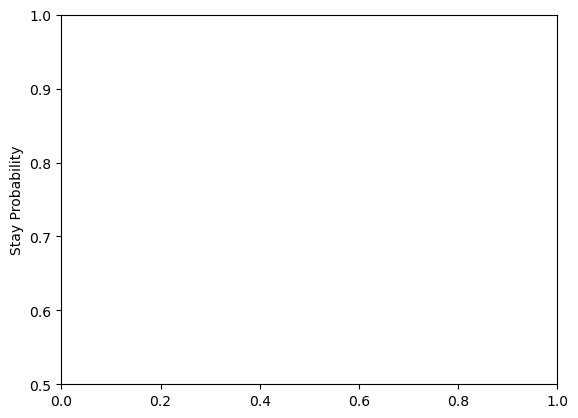

In [11]:
# final plot of the different seeds

episode_count = 300
common_sum = np.array([0.,0.])
uncommon_sum = np.array([0.,0.])

fig, ax = plt.subplots()

for i in range(n_seeds):

    x = np.arange(2)
    ax.set_ylim([0.5, 1.0])
    ax.set_ylabel('Stay Probability')
    
    common, uncommon = collect_seed_transition_probs[i]
    
    common_sum += np.array(common)
    uncommon_sum += np.array(uncommon)

    ax.set_xticks([1.3,3.3])
    ax.set_xticklabels(['Last trial rewarded', 'Last trial not rewarded'])

    plt.plot([1,3], common, 'o', color='black');
    plt.plot([1.8,3.8], uncommon, 'o', color='black');
    
c = plt.bar([1.,3.],  (1. / n_seeds) * common_sum, color='b', width=0.5)
uc = plt.bar([1.8,3.8], (1. / n_seeds) * uncommon_sum, color='r', width=0.5)
ax.legend( (c[0], uc[0]), ('common', 'uncommon') )
plt.savefig(dir_name +"/final_plot.png")